In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1 - Using TCN- TCN is a powerful and efficient alternative to RNNs for sequential data tasks, using only convolutional layers to capture both short-term and long-term patterns without needing recurrence.

In [3]:
!pip install keras-tcn

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Input
from keras.optimizers import Adam
from keras import regularizers
from tcn import TCN
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder

In [12]:
df = pd.read_csv('/content/drive/MyDrive/Fraud_modified_data.csv')

In [13]:
print(df.head())
print(df.info())


   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10033 entries, 0 to 10032
Data columns (total 11 column

In [14]:
if df.isnull().sum().sum() > 0:

    df.fillna(df.mean(), inplace=True)
else:
    print("✅ No missing values detected.")

✅ No missing values detected.


In [15]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    print(f"⚙️ Encoding categorical columns: {list(categorical_cols)}")
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
else:
    print("✅ No categorical columns to encode.")


⚙️ Encoding categorical columns: ['type', 'nameOrig', 'nameDest']


In [20]:
X = df.drop('isFraud', axis=1)  # if want to conver it in ndarray pur .value in last of x and y
y = df['isFraud']

In [21]:
X.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud
0,1,3,9839.64,1162,170136.0,160296.36,3719,0.0,0.0,0
1,1,3,1864.28,3490,21249.0,19384.72,3921,0.0,0.0,0
2,1,4,181.00,1571,181.0,0.00,719,0.0,0.0,0
3,1,1,181.00,9202,181.0,0.00,626,21182.0,0.0,0
4,1,3,11668.14,5494,41554.0,29885.86,1572,0.0,0.0,0


In [22]:
X.shape

(10033, 10)

In [23]:
y.shape

(10033,)

In [24]:
y.head()

,isFraud
0,0
1,0
2,1
3,1
4,0


In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
X_tcn = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_tcn, y, test_size=0.2, random_state=42, stratify=y)
# we use stratify here to handel the imbalanced data


In [30]:
# Build TCN Model
model = Sequential()
model.add(TCN(64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


In [46]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1 , validation_data=(X_test, y_test))

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9933 - loss: 0.0205 - val_accuracy: 0.9950 - val_loss: 0.0189
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9948 - loss: 0.0168 - val_accuracy: 0.9950 - val_loss: 0.0176
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.9926 - loss: 0.0227 - val_accuracy: 0.9950 - val_loss: 0.0193
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9944 - loss: 0.0187 - val_accuracy: 0.9950 - val_loss: 0.0177
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9916 - loss: 0.0230 - val_accuracy: 0.9950 - val_loss: 0.0220
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.9937 - loss: 0.0185 - val_accuracy: 0.9950 - val_loss: 0.0195
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9935 - loss: 0.0192 - val_accuracy: 0.9950 - val_loss: 0.0186
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.9936 - loss: 0.0184 - 

In [47]:
train_preds = (model.predict(X_train) > 0.5).astype(int)
test_preds = (model.predict(X_test) > 0.5).astype(int)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print(f"✅ TCN Training Accuracy: {train_acc:.4f}")
print(f"✅ TCN Testing Accuracy: {test_acc:.4f}")

251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
✅ TCN Training Accuracy: 0.9940
✅ TCN Testing Accuracy: 0.9950


In [48]:
classes = np.unique(y)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = dict(zip(classes, class_weights))

In [49]:
# Stratified K-Fold Setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Metric Lists
tcn_accuracy, tcn_precision, tcn_recall, tcn_f1, tcn_roc_auc = [], [], [], [], []

# Cross-Validation Loop
for train_idx, val_idx in kf.split(X_tcn, y):
    X_fold_train, X_fold_val = X_tcn[train_idx], X_tcn[val_idx]
    y_fold_train, y_fold_val = y[train_idx], y[val_idx]

    # Define Model
    model = Sequential([
        TCN(64, activation='relu', input_shape=(X_fold_train.shape[1], 1)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

In [50]:
 # Train
model.fit(X_fold_train, y_fold_train, epochs=10, batch_size=32, verbose=0, class_weight=class_weight_dict)


In [51]:
  # Predict
y_pred_prob = model.predict(X_fold_val)
y_pred = (y_pred_prob > 0.5).astype(int)

    # Collect Metrics
tcn_accuracy.append(accuracy_score(y_fold_val, y_pred))
tcn_precision.append(precision_score(y_fold_val, y_pred, zero_division=0))
tcn_recall.append(recall_score(y_fold_val, y_pred))
tcn_f1.append(f1_score(y_fold_val, y_pred))
tcn_roc_auc.append(roc_auc_score(y_fold_val, y_pred_prob))


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


In [52]:
# Print Cross-Validation Results
print("\n✅ TCN Cross-Validation Results")
print(f"Accuracy: {np.mean(tcn_accuracy):.4f}")
print(f"Precision: {np.mean(tcn_precision):.4f}")
print(f"Recall: {np.mean(tcn_recall):.4f}")
print(f"F1-Score: {np.mean(tcn_f1):.4f}")
print(f"ROC AUC: {np.mean(tcn_roc_auc):.4f}")


✅ TCN Cross-Validation Results
Accuracy: 0.9023
Precision: 0.0580
Recall: 0.9231
F1-Score: 0.1091
ROC AUC: 0.9759


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


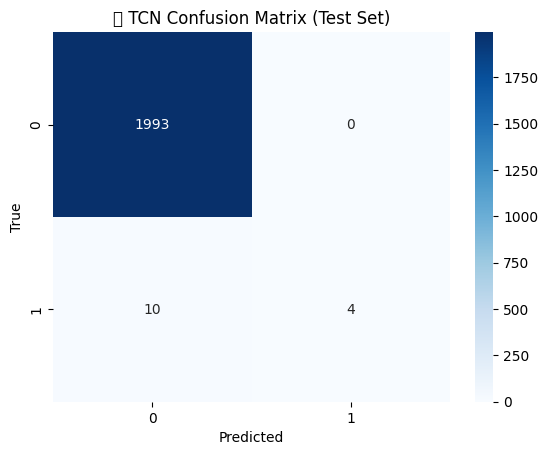

In [53]:
# Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('✅ TCN Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


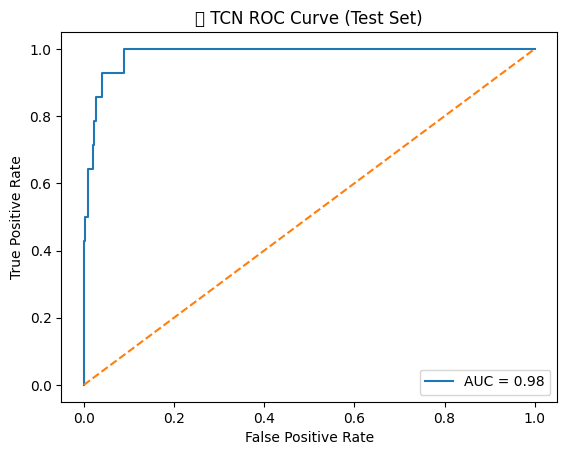

In [54]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('✅ TCN ROC Curve (Test Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


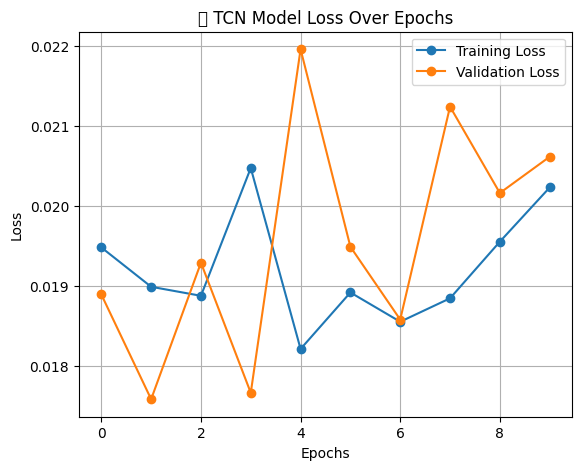

In [56]:
#Plot Loss and Accuracy
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('📉 TCN Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

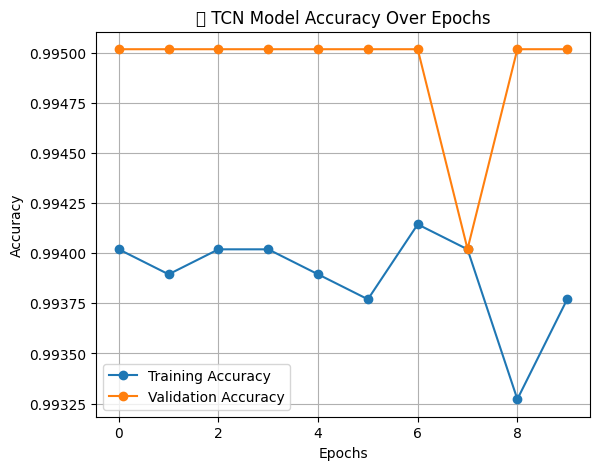

In [60]:
# Accuracy plot
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('📈 TCN Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

NOW- HYBRID CNN-SVM MODEL
A Hybrid CNN-SVM model uses a Convolutional Neural Network (CNN) to automatically extract high-level features from input data, and then applies a Support Vector Machine (SVM) classifier on those features for more accurate and robust final classification.

In [61]:
# Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Expand dims for CNN input (Conv1D needs 3D input)
X_train_cnn = np.expand_dims(X_train, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)


In [66]:
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1,activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [67]:
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [68]:
# Train CNN and store history
history_cnn = cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_test_cnn, y_test))


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9792 - loss: 0.1219 - val_accuracy: 0.9930 - val_loss: 0.0491
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9932 - loss: 0.0404 - val_accuracy: 0.9930 - val_loss: 0.0321
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9922 - loss: 0.0393 - val_accuracy: 0.9935 - val_loss: 0.0280
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9937 - loss: 0.0309 - val_accuracy: 0.9935 - val_loss: 0.0272
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9926 - loss: 0.0345 - val_accuracy: 0.9940 - val_loss: 0.0258
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9941 - loss: 0.0283 - val_accuracy: 0.9935 - val_loss: 0.0257
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9940 - loss: 0.0285 - val_accuracy: 0.9940 - val_loss: 0.0242
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9935 - loss: 0.0296 - val_accuracy: 0.

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


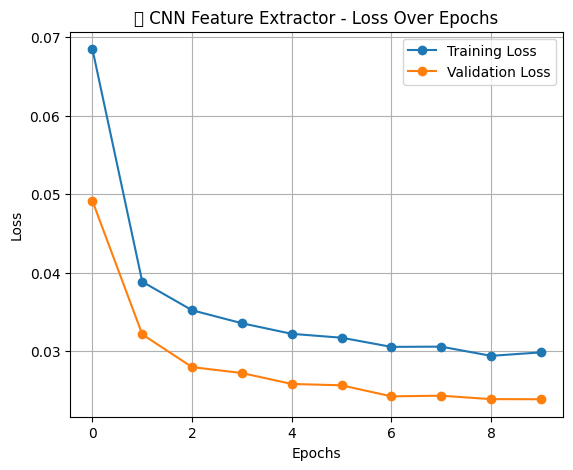

In [69]:
# Plot Loss and Accuracy
plt.figure(figsize=(14, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Training Loss', marker='o')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss', marker='o')
plt.title('📉 CNN Feature Extractor - Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


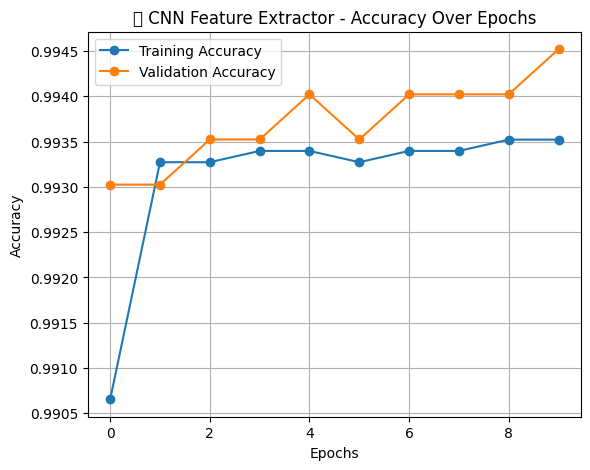

In [70]:
# Accuracy Plot
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('📈 CNN Feature Extractor - Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

In [71]:
# Extract features
X_train_features = cnn_model.predict(X_train_cnn)
X_test_features = cnn_model.predict(X_test_cnn)

# Train SVM on extracted features
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train_features, y_train)

# Train/Test Evaluation
y_train_pred = svm_model.predict(X_train_features)
y_test_pred = svm_model.predict(X_test_features)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"✅ CNN-SVM Training Accuracy: {train_acc:.4f}")
print(f"✅ CNN-SVM Testing Accuracy: {test_acc:.4f}")


251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
✅ CNN-SVM Training Accuracy: 0.9943
✅ CNN-SVM Testing Accuracy: 0.9950


In [73]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cnnsvm_accuracy, cnnsvm_precision, cnnsvm_recall, cnnsvm_f1, cnnsvm_roc_auc = [], [], [], [], []

for train_idx, val_idx in kf.split(X_scaled, y):
    X_tr, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Reshape
    X_tr_cnn = np.expand_dims(X_tr, axis=2)
    X_val_cnn = np.expand_dims(X_val, axis=2)

    # CNN feature extractor
    feature_model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_tr_cnn.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1,activation='sigmoid')
    ])
    feature_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    feature_model.fit(X_tr_cnn, y_tr, epochs=10, batch_size=32, verbose=0)

    # Extract features
    X_tr_features = feature_model.predict(X_tr_cnn)
    X_val_features = feature_model.predict(X_val_cnn)

    # Train SVM
    svm = SVC(kernel='rbf', probability=True)
    svm.fit(X_tr_features, y_tr)

    y_val_pred = svm.predict(X_val_features)
    y_val_pred_prob = svm.predict_proba(X_val_features)[:, 1]

    cnnsvm_accuracy.append(accuracy_score(y_val, y_val_pred))
    cnnsvm_precision.append(precision_score(y_val, y_val_pred, zero_division=0))
    cnnsvm_recall.append(recall_score(y_val, y_val_pred))
    cnnsvm_f1.append(f1_score(y_val, y_val_pred))
    cnnsvm_roc_auc.append(roc_auc_score(y_val, y_val_pred_prob))

# Final Cross-Validation Results
print("✅ CNN-SVM Cross-Validation Results")
print(f"Accuracy: {np.mean(cnnsvm_accuracy):.4f}")
print(f"Precision: {np.mean(cnnsvm_precision):.4f}")
print(f"Recall: {np.mean(cnnsvm_recall):.4f}")
print(f"F1-Score: {np.mean(cnnsvm_f1):.4f}")
print(f"ROC AUC: {np.mean(cnnsvm_roc_auc):.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ CNN-SVM Cross-Validation Results
Accuracy: 0.9938
Precision: 0.8000
Recall: 0.1044
F1-Score: 0.1802
ROC AUC: 0.5597


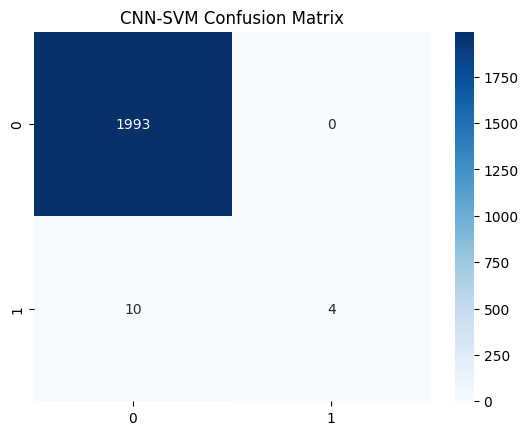

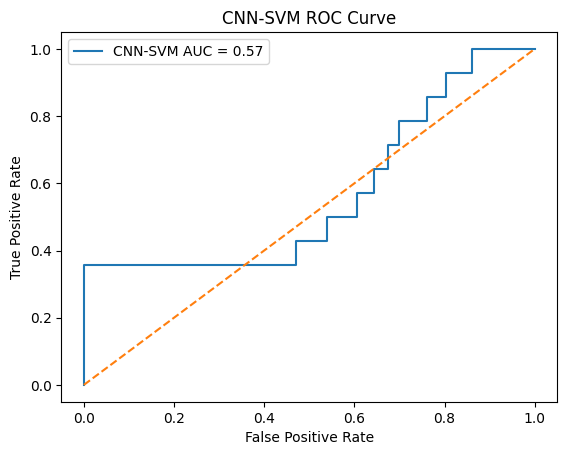

In [74]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('CNN-SVM Confusion Matrix')
plt.show()

# ROC Curve
y_test_prob = svm_model.predict_proba(X_test_features)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'CNN-SVM AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('CNN-SVM ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


*XGBoost* -XGBoost is a powerful and efficient machine learning algorithm that builds an ensemble of boosted decision trees to achieve high predictive accuracy, especially for structured tabular data.

In [75]:
# Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [76]:
import xgboost as xgb

# Create XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)


In [77]:
# Train and store evaluation history
eval_set = [(X_train, y_train), (X_test, y_test)]
history = xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=10)


[0]	validation_0-logloss:0.12910	validation_1-logloss:0.13018
[10]	validation_0-logloss:0.05019	validation_1-logloss:0.05316


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:01:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-logloss:0.02230	validation_1-logloss:0.02630
[30]	validation_0-logloss:0.01129	validation_1-logloss:0.01608
[40]	validation_0-logloss:0.00648	validation_1-logloss:0.01239
[50]	validation_0-logloss:0.00422	validation_1-logloss:0.01094
[60]	validation_0-logloss:0.00316	validation_1-logloss:0.01055
[70]	validation_0-logloss:0.00243	validation_1-logloss:0.01022
[80]	validation_0-logloss:0.00203	validation_1-logloss:0.01059
[90]	validation_0-logloss:0.00178	validation_1-logloss:0.01056
[99]	validation_0-logloss:0.00162	validation_1-logloss:0.01064


In [80]:
# Plot Learning Curves (Loss)
results = xgb_model.evals_result()



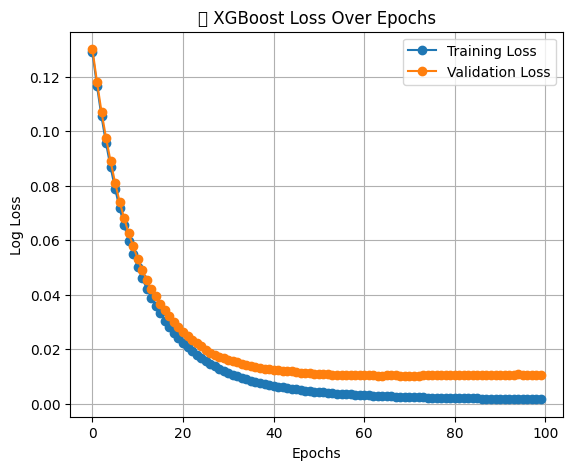

In [81]:
# Loss Plot
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.plot(results['validation_0']['logloss'], label='Training Loss', marker='o')
plt.plot(results['validation_1']['logloss'], label='Validation Loss', marker='o')
plt.title('📉 XGBoost Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.grid()

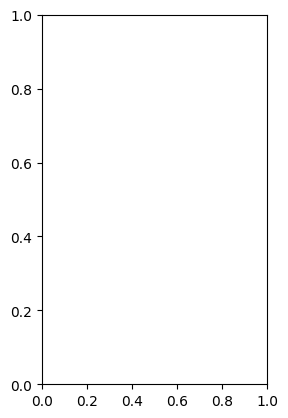

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


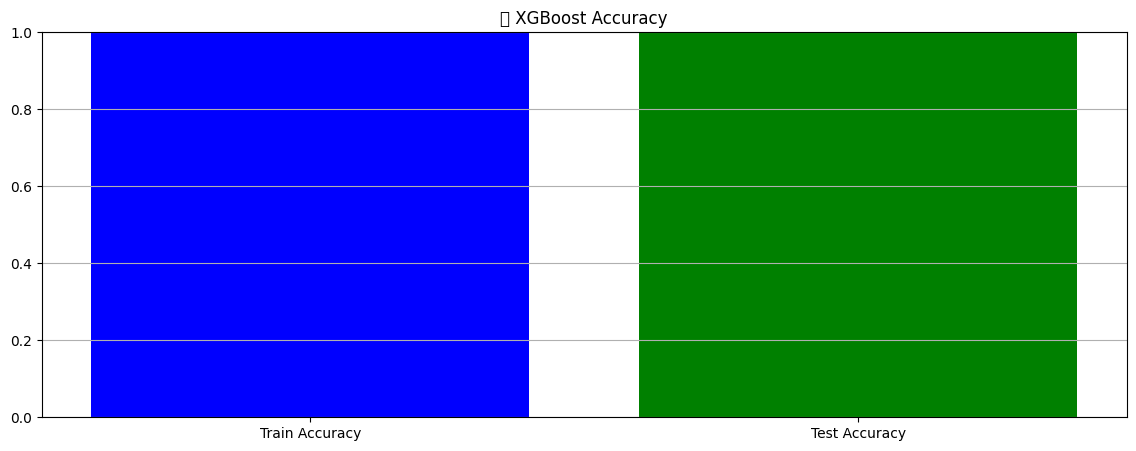

✅ XGBoost Training Accuracy: 0.9999
✅ XGBoost Testing Accuracy: 0.9975


In [82]:
# Accuracy manually
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

# Accuracy Display

plt.subplot(1, 2, 2)
plt.figure(figsize=(14,5))
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc, test_acc], color=['blue', 'green'])
plt.title('📈 XGBoost Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')

plt.show()

print(f"✅ XGBoost Training Accuracy: {train_acc:.4f}")
print(f"✅ XGBoost Testing Accuracy: {test_acc:.4f}")

In [83]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_accuracy, xgb_precision, xgb_recall, xgb_f1, xgb_roc_auc = [], [], [], [], []

for train_idx, val_idx in kf.split(X_scaled, y):
    X_tr, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    model.fit(X_tr, y_tr, verbose=0)

    y_val_pred = model.predict(X_val)
    y_val_pred_prob = model.predict_proba(X_val)[:, 1]

    xgb_accuracy.append(accuracy_score(y_val, y_val_pred))
    xgb_precision.append(precision_score(y_val, y_val_pred, zero_division=0))
    xgb_recall.append(recall_score(y_val, y_val_pred))
    xgb_f1.append(f1_score(y_val, y_val_pred))
    xgb_roc_auc.append(roc_auc_score(y_val, y_val_pred_prob))

# Final Cross-Validation Results
print("✅ XGBoost Cross-Validation Results")
print(f"Accuracy: {np.mean(xgb_accuracy):.4f}")
print(f"Precision: {np.mean(xgb_precision):.4f}")
print(f"Recall: {np.mean(xgb_recall):.4f}")
print(f"F1-Score: {np.mean(xgb_f1):.4f}")
print(f"ROC AUC: {np.mean(xgb_roc_auc):.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:03:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:03:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:03:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:03:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:03:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

✅ XGBoost Cross-Validation Results
Accuracy: 0.9972
Precision: 0.9618
Recall: 0.6187
F1-Score: 0.7476
ROC AUC: 0.9985


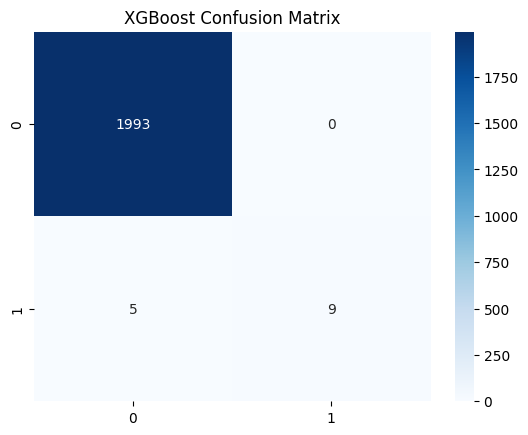

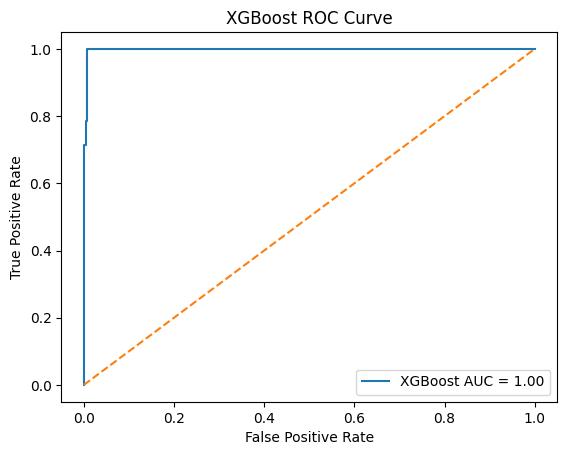

In [84]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('XGBoost Confusion Matrix')
plt.show()

# ROC Curve
y_test_prob = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'XGBoost AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('XGBoost ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


LSTM-LSTM is a type of recurrent neural network (RNN) designed to effectively learn long-term dependencies in sequential data by using special memory cells to retain important information over time.

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam

# Standard Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for LSTM (expects 3D input: samples, timesteps, features)
X_lstm = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y, test_size=0.2, random_state=42, stratify=y)


In [86]:
# Build LSTM model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])




In [87]:
# Train LSTM model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=15, batch_size=64, verbose=1)

Epoch 1/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9499 - loss: 0.3362 - val_accuracy: 0.9930 - val_loss: 0.0421
Epoch 2/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9931 - loss: 0.0420 - val_accuracy: 0.9930 - val_loss: 0.0423
Epoch 3/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9930 - loss: 0.0418 - val_accuracy: 0.9930 - val_loss: 0.0437
Epoch 4/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9926 - loss: 0.0453 - val_accuracy: 0.9930 - val_loss: 0.0413
Epoch 5/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9931 - loss: 0.0418 - val_accuracy: 0.9930 - val_loss: 0.0408
Epoch 6/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9918 - loss: 0.0453 - val_accuracy: 0.9930 - val_loss: 0.0403
Epoch 7/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9941 - loss: 0.0347 - val_accuracy: 0.9930 - val_loss: 0.0394
Epoch 8/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9926 - loss: 0.0408 - val_accu

In [88]:
# Predictions
train_preds = (model.predict(X_train) > 0.5).astype(int)
test_preds = (model.predict(X_test) > 0.5).astype(int)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print(f"✅ LSTM Training Accuracy: {train_acc:.4f}")
print(f"✅ LSTM Testing Accuracy: {test_acc:.4f}")

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
✅ LSTM Training Accuracy: 0.9934
✅ LSTM Testing Accuracy: 0.9935


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


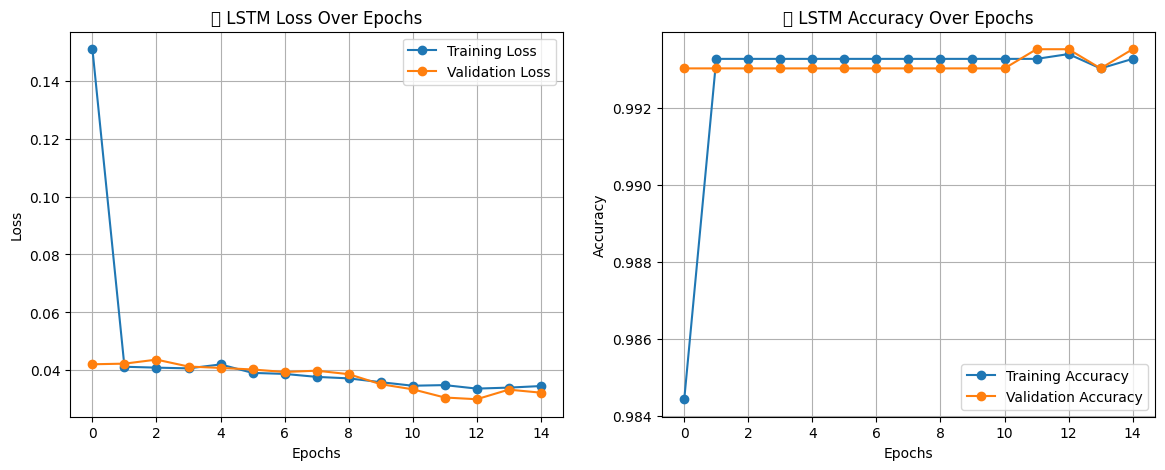

In [89]:
# Plot Loss
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('📉 LSTM Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('📈 LSTM Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()


In [90]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lstm_accuracy, lstm_precision, lstm_recall, lstm_f1, lstm_roc_auc = [], [], [], [], []

for train_idx, val_idx in kf.split(X_lstm, y):
    X_tr, X_val = X_lstm[train_idx], X_lstm[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = Sequential()
    model.add(Input(shape=(X_tr.shape[1], 1)))
    model.add(LSTM(64, activation='tanh', return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_tr, y_tr, epochs=15, batch_size=64, verbose=0)

    y_val_prob = model.predict(X_val)
    y_val_pred = (y_val_prob > 0.5).astype(int)

    lstm_accuracy.append(accuracy_score(y_val, y_val_pred))
    lstm_precision.append(precision_score(y_val, y_val_pred, zero_division=0))
    lstm_recall.append(recall_score(y_val, y_val_pred))
    lstm_f1.append(f1_score(y_val, y_val_pred))
    lstm_roc_auc.append(roc_auc_score(y_val, y_val_prob))

# Cross-Validation Results
print("✅ LSTM Cross-Validation Results")
print(f"Accuracy: {np.mean(lstm_accuracy):.4f}")
print(f"Precision: {np.mean(lstm_precision):.4f}")
print(f"Recall: {np.mean(lstm_recall):.4f}")
print(f"F1-Score: {np.mean(lstm_f1):.4f}")
print(f"ROC AUC: {np.mean(lstm_roc_auc):.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
✅ LSTM Cross-Validation Results
Accuracy: 0.9931
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
ROC AUC: 0.9138
